### 1.  Stochastic simulation of transcription and translation. (15 points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import odeint


In [ ]:
rng= np.random.default_rng()

## Implemenation of the Gillespie Direct Method

In [ ]:
# Model definition
def a_bd(x):
    W_in_x=10
    W_in_y=10
    W_out=1
    return(np.array([W_in_x, W_out*x[0], W_in_y*x[0], W_out*x[1]]))

S_bd= np.array([[1,-1,0,0],[0,0,1,-1]])
 
def run_ssa(X0,prop,S,maxsteps=1000,n_traj=10,rng=rng):
    # Arrays for storing trajectory events
    t_arr= np.zeros((n_traj,maxsteps))
    X_arr= np.zeros((n_traj,maxsteps,len(X0)))

    for n in range(n_traj):
        #0
        t=0
        X=X0.copy(); a=prop(X); atot= sum(a)
        
        t_arr[n,0]= 0.0
        X_arr[n,0,:]= X[:]

        for i in range(1,maxsteps):
            # 1
            r1= rng.random()
            t_next= t - np.log(r1)/atot

            # 2_x
            r2= rng.random()
            asum=0.0
            for j in range(len(a)): # 4 reactions
                asum+= a[j]/atot
                if (asum>r2):
                    break
            j_next =j

            # 3
            t= t_next
            X+= S[:,j_next] # execute 1 reaction

            t_arr[n,i]= t
            X_arr[n,i,:]= X[:]

            # 4 
            a=prop(X); atot= sum(a)
    return(t_arr,X_arr)


## Sample trajectories for the birth-death model

In [ ]:
t_arr, X_arr = run_ssa(np.array([0,0]), a_bd, S_bd, maxsteps=3000,n_traj=400)

## Plot trajectories

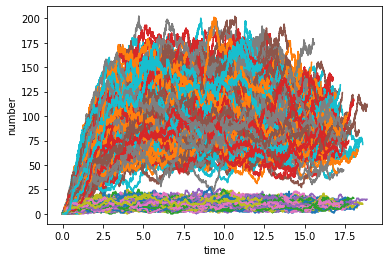

In [ ]:
for n in range(len(t_arr)):
    t= t_arr[n,:]
    x= X_arr[n,:,0]
    y= X_arr[n,:,1]
    plt.step(t,x,'-',where='post')
    plt.step(t,y,'-',where='post')
    #plt.legend(['X', 'Y'])
    plt.xlabel('time')
    plt.ylabel('number')
    #plt.xlim([0,10])
    #plt.ylim([0,100])

## Resample trajectories and compute averages

In [ ]:
'''Resample time series of unevenly spaces points on new grid'''
def resample(t,y,tnew):
    snew= (len(tnew),)+ y.shape[1:]
    ynew= np.zeros(snew)
    ic=0
    for i in range(len(tnew)):
        if (t[ic]>tnew[i]):
            ynew[i]= y[max(ic-1,0)].copy()
        else:
            # find next time point in sample
            for ip in range(ic+1,len(t)):
                if (t[ip]>tnew[i]):
                    break
            ic=ip
            ynew[i]=y[ic-1].copy()
    return(tnew,ynew)

In [ ]:
tre= np.linspace(0,25,3000)
Xre=np.zeros((len(t_arr),len(tre),X_arr.shape[2]) )
for n in range(len(t_arr)):
    t,xre=resample(t_arr[n,:],X_arr[n],tre)
    Xre[n,:,:]= xre

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


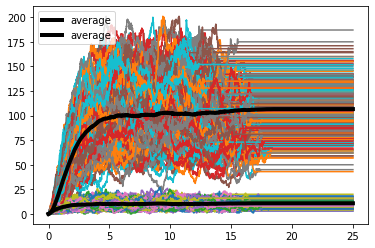

In [ ]:
for n in range(0,len(Xre),1):
    plt.plot(tre, Xre[n,:])
plt.plot(tre, np.average(Xre[:,:],axis=0),color='black',linewidth=4,label="average")
plt.legend()

### Test to make sure that resampling is done correctly

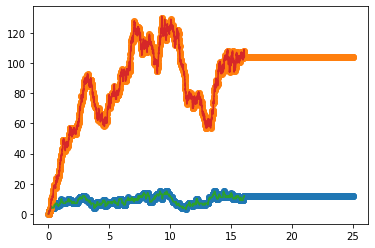

In [ ]:
plt.plot(tre,Xre[0,:,0],'-o')
plt.plot(tre,Xre[0,:,1],'-o')
plt.step(t_arr[0,:], X_arr[0,:,0],where="post")
plt.step(t_arr[0,:], X_arr[0,:,1],where="post")

#plt.xlim([0,100])

## Calculate expected steady state value of $X$ and compare with exact value

In [ ]:
t_arr, X_arr = run_ssa(np.array([10,100]), a_bd, S_bd, maxsteps=10000,n_traj=20)

In [ ]:
X_arr.shape

(20, 10000, 2)

In [ ]:
np.mean(X_arr[:,1000:],axis=0)

array([[  9.35,  99.35],
       [  9.4 ,  99.7 ],
       [  9.45,  99.35],
       ...,
       [ 11.85, 106.95],
       [ 11.65, 106.75],
       [ 11.6 , 106.4 ]])

In [ ]:
np.mean(np.mean(X_arr[:,1000:],axis=1),axis=0)

array([ 10.7241    , 105.38734444])

In [ ]:
a=a_bd([10,100]) ###?????? what number to use
x_exact= np.array([[a[0]/a[1]], [a[2]/a[3]]])
print(x_exact)
# Print residual of <X>
resid = (np.mean(X_arr[:,1000:],axis=1).transpose()-x_exact)

[[1.]
 [1.]]


In [ ]:
#print(resid)
print(np.mean(resid, axis=1))

[  9.7241     104.38734444]


In [ ]:
resid_x = np.sum(np.diff(t_arr[:,1000:])*X_arr[:,1000:-1,0],1)/(t_arr[:,-1]-t_arr[:,1000]) - x_exact[0]
#print(resid_x)
print(np.mean(resid_x))

9.048689766367945


In [ ]:
resid_y = np.sum(np.diff(t_arr[:,1000:])*X_arr[:,1000:-1,1],1)/(t_arr[:,-1]-t_arr[:,1000]) - x_exact[1]
#print(resid_y)
print(np.mean(resid_y))

99.72660689658827


## Comparison of steady state distribution with Poisson

In [ ]:
# For steady state properties we can simulate with one long trajectory. To avoid burnin, we'll start with
# X0=10

def a_bd(x):
    W_in_x=10
    W_in_y=10
    W_out=1
    return(np.array([W_in_x, W_out*x[0], W_in_y*x[0], W_out*x[1]]))

t_arr, X_arr = run_ssa(np.array([10,100]), a_bd, S_bd, maxsteps=1000000,n_traj=1)


In [ ]:
tre= np.linspace(0, t_arr[0,-1],1000000)
t,xre=resample(t_arr[0,:],X_arr[0],tre)
print(np.average(X_arr, axis=1),np.average(xre, axis=0), x_exact)
print(np.var(X_arr, axis=1),np.var(xre, axis=0))

[[ 10.716737 104.649353]] [10.023164 99.795677] [[1.]
 [1.]]
[[  9.80147307 565.53394768]] [  9.66858343 559.24653511]


In [ ]:
CV = np.std(xre, axis=0)/np.mean(xre, axis=0)
Fano = np.var(xre, axis=0)/np.mean(xre, axis=0)
print(CV)
print(Fano)

[0.31022485 0.23696812]
[0.96462389 5.60391544]


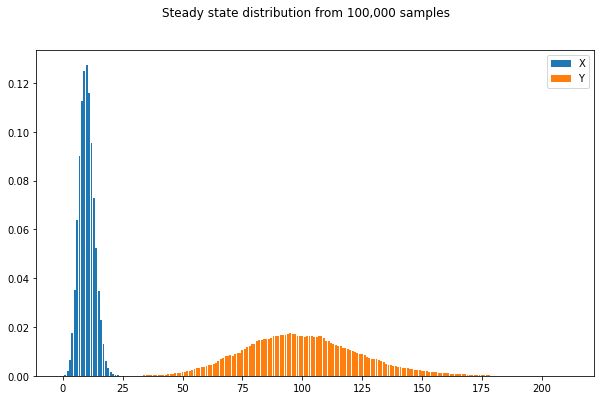

In [ ]:
bins = np.arange(0, xre.max() + 1.5) - 0.5
hist_x, bins= np.histogram(xre[:,0],bins,density=True)
hist_y, bins= np.histogram(xre[:,1],bins,density=True)

bvals = bins[:-1] + 0.5

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6),sharex=True)
fig.suptitle('Steady state distribution from 100,000 samples')
ax.set_xticks(bins + 0.5)
ax.bar(bvals,hist_x,label=f'X')
ax.bar(bvals,hist_y,label=f'Y')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax.legend()

### Q1c

In [ ]:
# Model definition
def a_bd(x,n):
    W_in_y=10
    W_out=1
    c = x[1]/50
    P_unbound = 1/(1+c**n)
    W_in_x=10* P_unbound
    return(np.array([W_in_x, W_out*x[0], W_in_y*x[0], W_out*x[1]]))

S_bd= np.array([[1,-1,0,0],[0,0,1,-1]])

def run_ssa(X0,prop,S,n,maxsteps=1000,n_traj=10,rng=rng):
    # Arrays for storing trajectory events
    t_arr= np.zeros((n_traj,maxsteps))
    X_arr= np.zeros((n_traj,maxsteps,len(X0)))

    for traj in range(n_traj):
        #0
        t=0
        X=X0.copy(); a=prop(X,n); atot= sum(a)
        
        t_arr[traj,0]= 0.0
        X_arr[traj,0,:]= X[:]

        for i in range(1,maxsteps):
            # 1
            r1= rng.random()
            t_next= t - np.log(r1)/atot

            # 2_x
            r2= rng.random()
            asum=0.0
            for j in range(len(a)): # 4 reactions
                asum+= a[j]/atot
                if (asum>r2):
                    break
            j_next =j

            # 3
            t= t_next
            X+= S[:,j_next] # execute 1 reaction

            t_arr[traj,i]= t
            X_arr[traj,i,:]= X[:]

            # 4 
            # c = X[1]/50
            # P_unbound = 1/(1+c**n)
            a=prop(X,n)
            # regulate x production rate
            # a[0]=a[0]* P_unbound
            atot= sum(a)

    return(t_arr,X_arr)


In [ ]:
#nvals=[1,2,6]
t_arr, X_arr = run_ssa(np.array([0,0]), a_bd, S_bd, 2, maxsteps=3000,n_traj=400)

#check

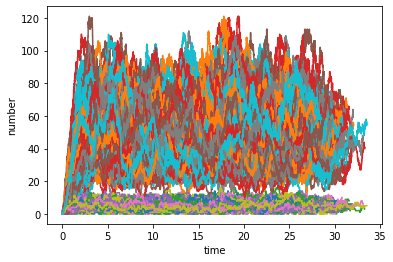

In [ ]:
for n in range(len(t_arr)):
    t= t_arr[n,:]
    x= X_arr[n,:,0]
    y= X_arr[n,:,1]
    plt.step(t,x,'-',where='post')
    plt.step(t,y,'-',where='post')
    plt.xlabel('time')
    plt.ylabel('number')

In [ ]:
tre= np.linspace(0,30,3000)
Xre=np.zeros((len(t_arr),len(tre),X_arr.shape[2]) )
for n in range(len(t_arr)):
    t,xre=resample(t_arr[n,:],X_arr[n],tre)
    Xre[n,:,:]= xre

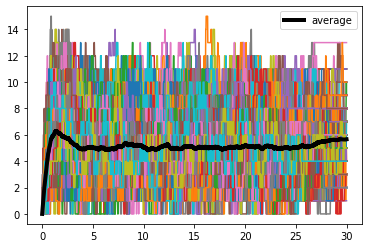

In [ ]:
for n in range(0,len(Xre),1):
    plt.plot(tre, Xre[n,:,0])
plt.plot(tre, np.average(Xre[:,:,0],axis=0),color='black',linewidth=4,label="average")
plt.legend()

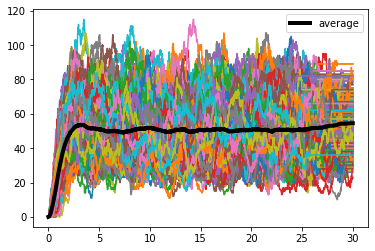

In [ ]:
for n in range(0,len(Xre),1):
    plt.plot(tre, Xre[n,:,1])
plt.plot(tre, np.average(Xre[:,:,1],axis=0),color='black',linewidth=4,label="average")
plt.legend()

In [ ]:
t_arr, X_arr = run_ssa(np.array([5,50]), a_bd, S_bd, 6, maxsteps=1000000,n_traj=1)

tre= np.linspace(0, t_arr[0,-1],100000)
t,xre=resample(t_arr[0,:],X_arr[0],tre)
#print(np.average(X_arr, axis=1),np.average(xre, axis=0), x_exact)

#CV = np.std(xre, axis=0)/np.mean(xre, axis=0)
Fano = np.var(xre, axis=0)/np.mean(xre, axis=0)
#print(CV)
print(Fano)

[0.72801381 2.14468163]


### Q2a

In [ ]:

def f(x):
    return (x + 2*x**2 + 3*x**3 + 4*x**4 + 10**10*5*x**5 - 1)

x = fsolve(f, 0.1)
x, f(x)+1

(array([0.00723712]), array([1.]))

In [ ]:
print(x)
print((10**10*5*x**5) / (x + 2*x**2 + 3*x**3 + 4*x**4 + 10**10*5*x**5))

[0.00723712]
[0.99265698]


### Q2b

In [ ]:
def f(x):
    return (((10**10*5*x**5) / (x + 2*x**2 + 3*x**3 + 4*x**4 + 10**10*5*x**5)) - 0.5)

x = fsolve(f, 0.0001)
x, f(x)+0.5

(array([0.00211698]), array([0.5]))

In [ ]:
print(x[0])
print(x + 2*x**2 + 3*x**3 + 4*x**4 + 10**10*5*x**5)

0.002116984525767212
[0.00425195]


In [ ]:
def conc_A1_ring(total_conc):
    coeff = [5*10**10, 4, 3, 2, 1, -total_conc]
    r = np.roots(coeff)
    real_valued = r.real[abs(r.imag)==0]
    return real_valued[0]

In [ ]:
print(conc_A1_ring(1))

0.0072371210895836


In [ ]:
total_monomer = np.linspace(0, 0.1, 10000)

x_ring = np.array([conc_A1_ring(i) for i in total_monomer])
# Hill, n = 1
Kd = 0.002116984525767212
single_bind = 1 / (1 + Kd/x_ring)

frac_monomer_ring = (10**10*5*x_ring**5) / (x_ring + 2*x_ring**2 + 3*x_ring**3 + 4*x_ring**4 + 10**10*5*x_ring**5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


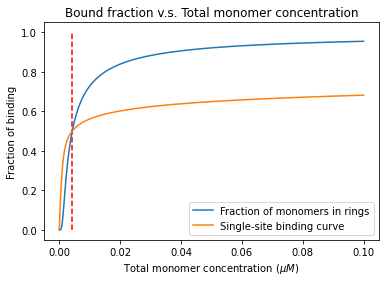

In [ ]:
plt.plot(total_monomer,frac_monomer_ring,label='Fraction of monomers in rings')
plt.plot(total_monomer,single_bind,label='Single-site binding curve')

plt.title("Bound fraction v.s. Total monomer concentration")

plt.vlines(0.00425195,0,1,color='red',linestyles='--')
plt.xlabel("Total monomer concentration ($\mu M$)")
plt.ylabel("Fraction of binding")

plt.legend()

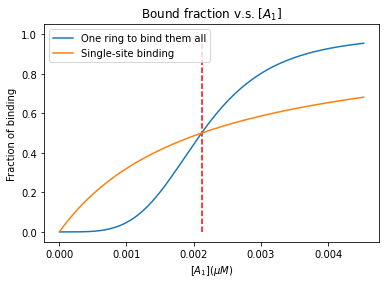

In [ ]:
plt.plot(x_ring,frac_monomer_ring,label='One ring to bind them all')
plt.plot(x_ring,single_bind,label='Single-site binding')

plt.title("Bound fraction v.s. $[A_{1}]$")

plt.vlines(0.00211698,0,1,color='red',linestyles='--')
plt.xlabel("$[A_{1}](\mu M$)")
plt.ylabel("Fraction of binding")

plt.legend()

### Q3a

In [ ]:
def f(x):
    return (1 + (20 * ((x/10)/(1+(x/10))))-x)

x = fsolve(f, 10)
x[0], f(x)

(11.84428877022472, array([2.30926389e-14]))

In [ ]:
def f(x):
    return (1 + (20 * ((x/10)**6/(1+(x/10)**6)))-x)

print(fsolve(f, 1)[0], fsolve(f, 10)[0], fsolve(f, 20)[0])

1.000020002380401 9.51284349619874 20.752727408104253


### Q3b

In [ ]:
def X_rate(x, n):
    dXdt = 1 + (20 * ((x/10)**n/(1+(x/10)**n))) -x
    return dXdt

def X_production(x, n):
    dXdt = 1 + (20 * ((x/10)**n/(1+(x/10)**n)))
    return dXdt

def X_remove(x, n):
    dXdt = x
    return dXdt

In [ ]:
x = np.linspace(0,20,1000)
plt.plot(x, X_production(x, 1), label="X production")
plt.plot(x, X_remove(x, 1), label="X removal")
plt.plot(x, X_rate(x, 1), label="X rate")


plt.vlines(11.84428877022472,0,20,color='red',linestyles='--')
plt.text(12,1,"$X = 11.84428877022472$")

plt.title("Trajectories of X")
plt.xlabel("$X$ concentration")
plt.ylabel("Rate")

plt.legend()

In [ ]:
def positive_regulation_model(x, t, n):
    dXdt = 1 + (20 * ((x/10)**n/(1+(x/10)**n))) -x
    return dXdt

# parameters
n = 1

# store all values for initial condition
X0 = 0

# time points
t = np.linspace(0,15,1000)

# solve ODE
y_out_n1 = odeint(positive_regulation_model, X0, t, args=(1,))
y_out_n6 = odeint(positive_regulation_model, X0, t, args=(6,))

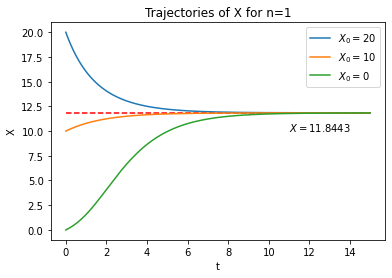

In [ ]:
# n=1
plt.plot(t, odeint(positive_regulation_model, 20, t, args=(1,)), label="$X_{0}=20$")
plt.plot(t, odeint(positive_regulation_model, 10, t, args=(1,)), label="$X_{0}=10$")
plt.plot(t, odeint(positive_regulation_model, 0, t, args=(1,)), label="$X_{0}=0$")


plt.hlines(11.84428877022472,0,15,color='red',linestyles='--')
plt.text(11,10,"$X = 11.8443$")

# plt.hlines(1.000020002380401,0,15,color='red',linestyles='--')
# plt.text(11,1.5,"$X = 1.0000$")

plt.title("Trajectories of X for n=1")
plt.xlabel("t")
plt.ylabel("X")

plt.legend(loc='best')

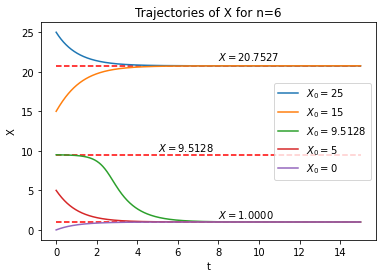

In [ ]:
# n=6
plt.plot(t, odeint(positive_regulation_model, 25, t, args=(6,)), label="$X_{0}=25$")
plt.plot(t, odeint(positive_regulation_model, 15, t, args=(6,)), label="$X_{0}=15$")
plt.plot(t, odeint(positive_regulation_model, 9.5, t, args=(6,)), label="$X_{0}=9.5128$")
plt.plot(t, odeint(positive_regulation_model, 5, t, args=(6,)), label="$X_{0}=5$")
plt.plot(t, odeint(positive_regulation_model, 0, t, args=(6,)), label="$X_{0}=0$")


# plt.hlines(11.84428877022472,0,15,color='red',linestyles='--')
# plt.text(11,10,"$X = 11.8443$")
# 1.000020002380401 9.51284349619874 20.752727408104253

plt.hlines(1.000020002380401,0,15,color='red',linestyles='--')
plt.text(8,1.5,"$X = 1.0000$")

plt.hlines(9.51284349619874,0,15,color='red',linestyles='--')
plt.text(5,10,"$X = 9.5128$")

plt.hlines(20.752727408104253,0,15,color='red',linestyles='--')
plt.text(8,21.5,"$X = 20.7527$")

plt.title("Trajectories of X for n=6")
plt.xlabel("t")
plt.ylabel("X")

plt.legend(loc='best')

### Q3c

In [ ]:
alpha = 1
beta1 = 1
beta2 = 20
K=10

# Steady state production and degradation rates as a function of Ap
# dXdt = beta1 + (beta2 * ((X/K)**n/(1+(X/K)**n))) - alpha*X
prod = lambda x: beta1 + (beta2 * ((x/K)**n/(1+(x/K)**n)))
deg  = lambda x: alpha*x
rate = lambda x: prod(x) - deg(x)

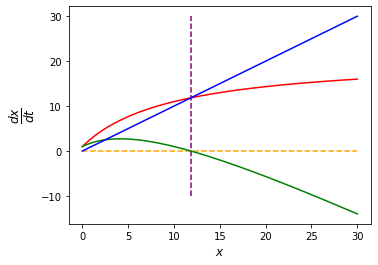

In [ ]:
# n=1
n=1
x= np.linspace(0,30,1000)
fig = plt.figure()
fig.subplots_adjust(left=0.2)
ax1= fig.add_subplot(111)
ax1.plot(x,prod(x),'r-')
ax1.plot(x,rate(x),'g-')
ax1.set_xlabel('$x$',fontsize='large')
ax1.set_ylabel(r'$\frac{dx}{dt}$',fontsize='xx-large')
#ax1.text(0.5,0.005,r'$T=c_1=1;$ $K_{m1}=10$',horizontalalignment='center')
fig.savefig('fig_autophos_rate_py.pdf',format='pdf')
ax1.plot(x,deg(x),'b-')

plt.hlines(0,0,30,color='orange',linestyles='--')
plt.vlines(11.84428877022472,-10,30,color='purple',linestyles='--')


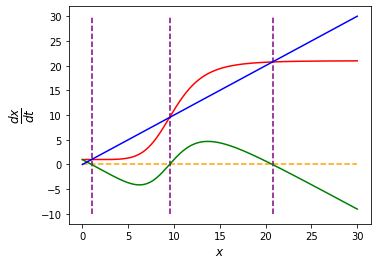

In [ ]:
# n=6
n=6
x= np.linspace(0,30,1000)
fig = plt.figure()
fig.subplots_adjust(left=0.2)
ax1= fig.add_subplot(111)
ax1.plot(x,prod(x),'r-')
ax1.plot(x,rate(x),'g-')
ax1.set_xlabel('$x$',fontsize='large')
ax1.set_ylabel(r'$\frac{dx}{dt}$',fontsize='xx-large')
#ax1.text(0.5,0.005,r'$T=c_1=1;$ $K_{m1}=10$',horizontalalignment='center')
fig.savefig('fig_autophos_rate_py.pdf',format='pdf')
ax1.plot(x,deg(x),'b-')

plt.hlines(0,0,30,color='orange',linestyles='--')
plt.vlines([1.000020002380401,9.51284349619874,20.752727408104253],-10,30,color='purple',linestyles='--')


In [ ]:
def f_dxddt(x):
    return 20*1/10*(x/10)**(-2)/((x/10)**(-1)+1)**2 - 1

print(fsolve(f_dxddt, 1)[0])

4.142135623730952


In [ ]:
# n=1
alpha = 1
beta1 = 1
beta2 = 20
K=10
n=1

# Steady state production and degradation rates as a function of Ap
# dXdt = beta1 + (beta2 * ((X/K)**n/(1+(X/K)**n))) - alpha*X
prod = lambda x: beta1 + (beta2 * ((x/K)**n/(1+(x/K)**n)))
deg  = lambda x: alpha*x
rate = lambda x: prod(x) - deg(x)

# beta1 as bifuraction parameter
beta1_vals = np.linspace(0,50,1000)
xs1=[]
# xs2=[]
xu=[]
for beta1 in beta1_vals:
    x1= fsolve(rate,0)[0]
    x2= fsolve(rate,10)[0]
    # x3= fsolve(rate,20)[0]
    if (x2>4.142135623730952):
        xs1.append([beta1,x2])
        # xs2.append([beta1,x3])
        xu.append([beta1,x1])
    else:
        xs1.append([beta1,x1])
        # xu.append([beta1,x2])
xs1= np.array(xs1)
# xs2= np.array(xs2)
xu= np.array(xu)


In [ ]:
xu[100,0]

5.005005005005005

Text(0.5, 1.0, 'Bifurcation Diagram for n = 1')

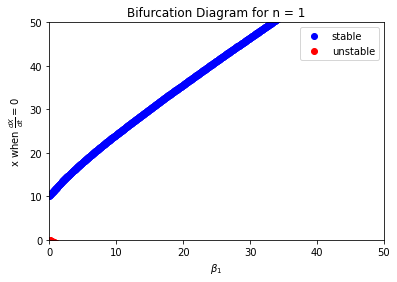

In [ ]:
plt.plot(xs1[:,0],xs1[:,1],'bo',label='stable')
plt.plot(xu[:100,0],xu[:100,1],'ro',label='unstable')
plt.xlabel(r'$\beta_{1}$')
plt.ylabel(r'x when $\frac{dX}{dt} = 0$ ')
plt.legend(loc='best')
plt.ylim([0, 50])
plt.xlim([0, 50])
plt.title("Bifurcation Diagram for n = 1")

In [ ]:
# n=6
def f_dxddt(x):
    return 20*6/10*(x/10)**(-6-1)/((x/10)**(-6)+1)**2 - 1

print(fsolve(f_dxddt, 5)[0])

6.222517183378383


In [ ]:
import warnings

warnings.filterwarnings("error")

alpha = 1
beta1 = 1
beta2 = 20
K=10
n=6

# Steady state production and degradation rates as a function of Ap
# dXdt = beta1 + (beta2 * ((X/K)**n/(1+(X/K)**n))) - alpha*X
prod = lambda x: beta1 + (beta2 * ((x/K)**n/(1+(x/K)**n)))
deg  = lambda x: alpha*x
rate = lambda x: prod(x) - deg(x)

# beta1 as bifuraction parameter
beta1_vals = np.linspace(0,50,1000)
xs1=[]
xs2=[]
xu=[]
for beta1 in beta1_vals:
    try:
        x1= fsolve(rate,1)[0]
        xs1.append([beta1,x1])
    except RuntimeWarning:
        print("fail x1")
    try:
        x2= fsolve(rate,10)[0]
        xu.append([beta1,x2])
    except RuntimeWarning:
        print("fail x2")
    try:
        x3= fsolve(rate,20)[0]
        xs2.append([beta1,x3])
    except RuntimeWarning:
        print("fail x3")

    # if (abs(x1-x2)<0.1) and (x2 < 20): 
    #     xs1.append([beta1,x1])
    #     xs2.append([beta1,x3])
    #     #xu.append([beta1,x2])
    # else:
    #     xs1.append([beta1,x1])
    #     xs2.append([beta1,x3])
    #     xu.append([beta1,x2])
xs1= np.array(xs1)
xs2= np.array(xs2)
xu= np.array(xu)


Text(0.5, 1.0, 'Bifurcation Diagram for n = 6')

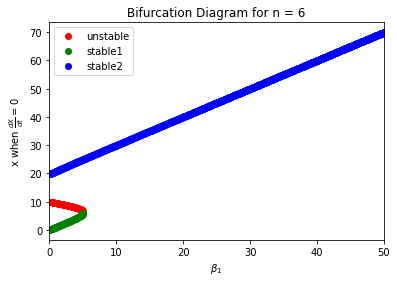

In [ ]:
plt.plot(xu[:,0],xu[:,1],'ro',label='unstable')

plt.plot(xs1[:,0],xs1[:,1],'go',label='stable1')
plt.plot(xs2[:,0],xs2[:,1],'bo',label='stable2')

plt.xlabel(r'$\beta_{1}$')
plt.ylabel(r'x when $\frac{dX}{dt} = 0$ ')
plt.legend(loc='best')
plt.xlim([0, 50])
plt.title("Bifurcation Diagram for n = 6")

### Q4c

In [ ]:
import os, re, sys, IPython, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from scipy import integrate

In [ ]:
warnings.filterwarnings("ignore")

Text(0, 0.5, '$\\lambda$')

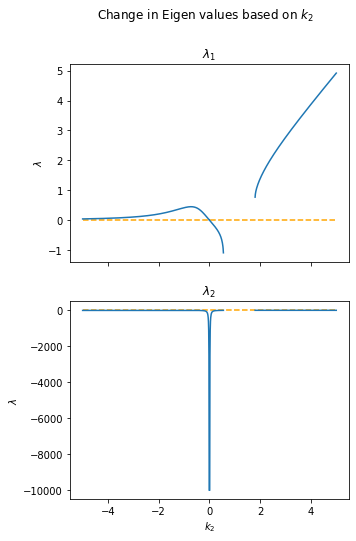

In [ ]:
k = np.linspace(-5,5,1001)

e1 = ((k**3)-1+np.sqrt((k**6)-(6*k**3)+1))/(2*k**2)
e2 = (k**3-1-np.sqrt(k**6-6*k**3+1))/(2*k**2)
fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(5, 8))

fig.suptitle('Change in Eigen values based on $k_2$')
ax1.plot(k, e1)
ax1.hlines(0,-5,5,color='orange',linestyles='--')

ax1.set_title(r'$\lambda_1$')
ax1.set_ylabel(r'$\lambda$')

ax2.plot(k, e2)
ax2.hlines(0,-5,5,color='orange',linestyles='--')
ax2.set_title(r'$\lambda_2$')
ax2.set_xlabel(r'$k_2$')
ax2.set_ylabel(r'$\lambda$')


Text(0, 0.5, '$\\lambda$')

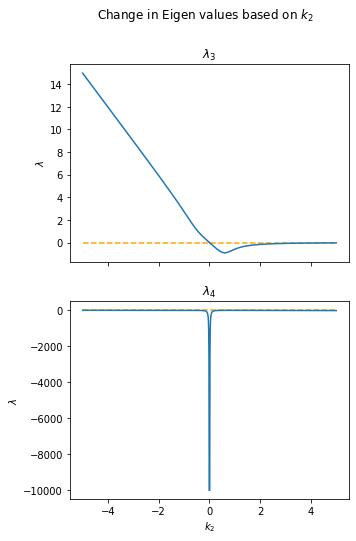

In [ ]:
e1 = (-3*k**3-1+np.sqrt(9*k**6-2*k**3+1))/(2*k**2)
e2 = (-3*k**3-1-np.sqrt(9*k**6-2*k**3+1))/(2*k**2)

fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(5, 8))

fig.suptitle('Change in Eigen values based on $k_2$')
ax1.plot(k, e1)
ax1.hlines(0,-5,5,color='orange',linestyles='--')

ax1.set_title(r'$\lambda_3$')
ax1.set_ylabel(r'$\lambda$')

ax2.plot(k, e2)
ax2.hlines(0,-5,5,color='orange',linestyles='--')
ax2.set_title(r'$\lambda_4$')
ax2.set_xlabel(r'$k_2$')
ax2.set_ylabel(r'$\lambda$')

### Q4d

In [ ]:
# Function for getting S, P values
def f(Y, t, k_2):
    S, P = Y
    return [1-((P**2)*S), ((P**2)*S) - (k_2*P)]

In [ ]:
k=np.array([-2,1,2])
print(((k**3)-1+np.sqrt((k**6)-(6*k**3)+1))/(2*k**2))
print((k**3-1-np.sqrt(k**6-6*k**3+1))/(2*k**2))

[0.20376823        nan 1.3903882 ]
[-2.45376823         nan  0.3596118 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, '$k_2 = 1$ (Stable)')

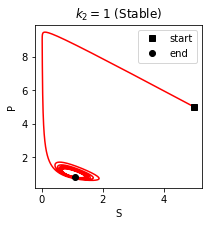

In [ ]:
# k=1
t = np.linspace(0, 50, 10000)
y0 = [5, 5]
ys = odeint(f, y0, t, args=(1,))
plt.figure(figsize=(3,3))
plt.plot(ys[:,0], ys[:,1], 'r-')
plt.plot([ys[0,0]], [ys[0,1]], 'ks', label='start')
plt.plot([ys[-1,0]], [ys[-1,1]], 'ko', label='end')
plt.legend()
plt.xlabel('S')
plt.ylabel('P')
plt.title('$k_2 = 1$ (Stable)')

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 1.0, '$k_2 = -1$ (Unstable)')

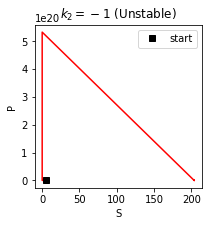

In [ ]:
# k=-1
t = np.linspace(0, 50, 10000)
y0 = [5, 5]
ys = odeint(f, y0, t, args=(-1,))
plt.figure(figsize=(3,3))
plt.plot(ys[:,0], ys[:,1], 'r-')
plt.plot([ys[0,0]], [ys[0,1]], 'ks', label='start')
#plt.plot([ys[-1,0]], [ys[-1,1]], 'ko', label='end')
plt.legend()
plt.xlabel('S')
plt.ylabel('P')
plt.title('$k_2 = -1$ (Unstable)')

Text(0.5, 1.0, '$k_2 = 0.5$ (Stable)')

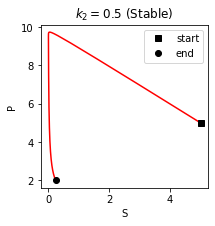

In [ ]:
# k=3
t = np.linspace(0, 50, 10000)
y0 = [5, 5]
ys = odeint(f, y0, t, args=(0.5,))
plt.figure(figsize=(3,3))
plt.plot(ys[:,0], ys[:,1], 'r-')
plt.plot([ys[0,0]], [ys[0,1]], 'ks', label='start')
plt.plot([ys[-1,0]], [ys[-1,1]], 'ko', label='end')
plt.legend()
plt.xlabel('S')
plt.ylabel('P')
plt.title('$k_2 = 0.5$ (Stable)')

### Q4e

In [ ]:
import os, re, sys, IPython, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from scipy import integrate

In [ ]:
# Function for getting S, P values
def f(Y, t=0, k2=1):
    S, P = Y
    return [1-((P**2)*S), ((P**2)*S) - (k2*P)]

In [ ]:
def phaseplane_linear (a, k2, t_end=1,x01= [2,2],x02= [-2,-2],filename='pp_lin.pdf'):

    # Compute eigenvalues
    w,v= np.linalg.eig(a)
    x_fp=np.array([0,0])

    # Compute trajectories
    t= np.linspace(0,t_end,1000)
    # p=a.flatten()
    sol1 =  integrate.odeint(f, x01, t, args=(k2,))
    sol2 =  integrate.odeint(f, x02, t, args=(k2,))


    fig = plt.figure(figsize=(12,6))
    ax1= fig.add_subplot(1,2,1)
    ax2= fig.add_subplot(1,2,2)

    ax1.plot(t, sol1[:,0], 'r-', label=r'$P$')
    ax1.plot(t, sol1[:,1], 'b-', label=r'$S$')
    ax1.set_xlabel('time')
    ax1.set_ylabel('number')
    ax1.set_title('Trajectories')
    ax1.legend(loc='best')
    ax1.grid()
    ax1.set_xlim(t[0],t[-1])

    # Plot nullclines and fp
    x1= np.linspace(-4,4,20)
    x2= np.linspace(-4,4,20)
    # Compute nullclines
    x1_null = lambda x1: -a[0,0]/a[0,1]*x1
    if (a[1,1]==0):
        x2_null_x = np.zeros(20)
        x2_null= x2
    else:
        x2_null_x = x1
        x2_null = -a[1,0]/a[1,1]*x1

    ax2.plot(x1, x1_null(x1),'r--', label="$P$ nullcline")
    ax2.plot(x2_null_x, x2_null,'b--', label="$S$ nullcline")
    ax2.plot([0], [0], linewidth=0, color='black', marker='o', markersize=7, markerfacecolor='white')
    ax2.set_xlim(x1.min(),x1.max())
    ax2.set_ylim(x2.min(),x2.max())

    # Plot trajectories
    ax2.plot(sol1[:,0], sol1[:,1], color='purple')
    ax2.plot(sol1[0,0], sol1[0,1], linewidth=0, color='black', marker='o', markersize=5) #,label='start')
    ax2.plot(sol1[-1,0], sol1[-1,1], linewidth=0, color='black', marker='s', markersize=5) #,label='end')
    ax2.plot(sol2[:,0], sol2[:,1], color='purple')
    ax2.plot(sol2[0,0], sol2[0,1], linewidth=0, color='black', marker='o', markersize=5)
    ax2.plot(sol2[-1,0], sol2[-1,1], linewidth=0, color='black', marker='s', markersize=5)

    ax2.set_xlabel(r'$P$')
    ax2.set_ylabel(r'$S$')

    # Show vector field
    X1, X2 = np.meshgrid(x1,x2)   # create grid
    DX1, DX2 = f([X1, X2],k2=k2) # compute derivs on grid
    M= (np.hypot(DX1,DX2)) # normalize derivs
    M[M==0]= 1             # avoid divide by 0
    #normalize arrows
    DX1 /= M
    DX2 /= M
    ax2.quiver(X1, X2, DX1, DX2, M, pivot='mid')

    ax2.set_title('Phase Plane with Nullclines')
    ax2.legend(loc='best')
    #ax2.set_xlim(0,1.2)
    #ax2.set_ylim(0,3)
    ax2.grid()


    print('a={}'.format(a))
    print('eigenvalues are {}'.format(w))
    fig.savefig(filename,facecolor='white')

a=[[-1. -2.]
 [ 1.  1.]]
eigenvalues are [-9.71445147e-17+1.j -9.71445147e-17-1.j]


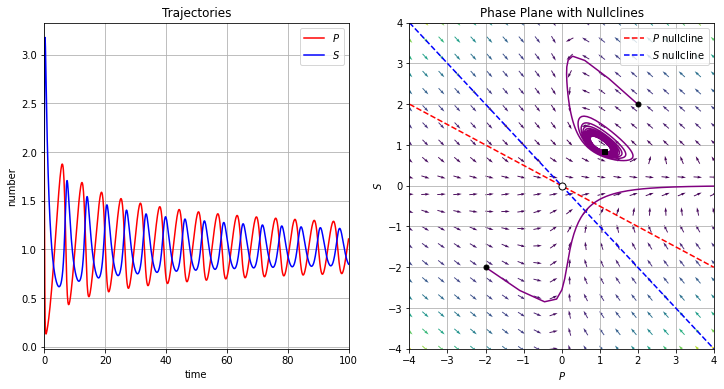

In [ ]:
# Stable example, k2=1
k2 = 1
a= np.array([[-1/k2**2, -2*k2],[1/k2**2, k2]])
phaseplane_linear(k2, t_end=100, filename="lin_unstable.pdf")

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


a=[[-1.  2.]
 [ 1. -1.]]
eigenvalues are [ 0.41421356 -2.41421356]


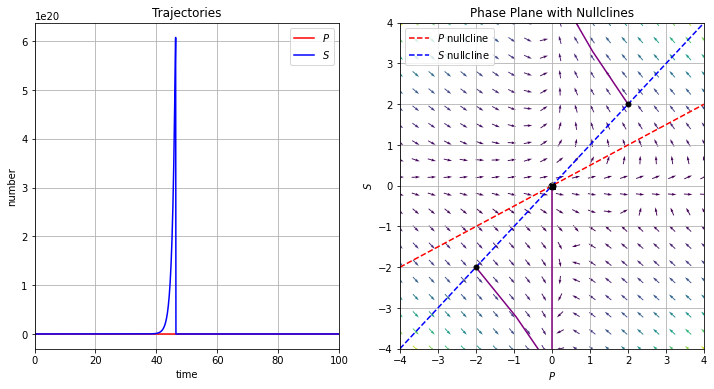

In [ ]:
# Unstable example, k2=-1
k2 = -1
a= np.array([[-1/k2**2, -2*k2],[1/k2**2, k2]])
phaseplane_linear(k2, t_end=100, filename="lin_unstable.pdf")


a=[[-4.  -1. ]
 [ 4.   0.5]]
eigenvalues are [-2.78077641 -0.71922359]


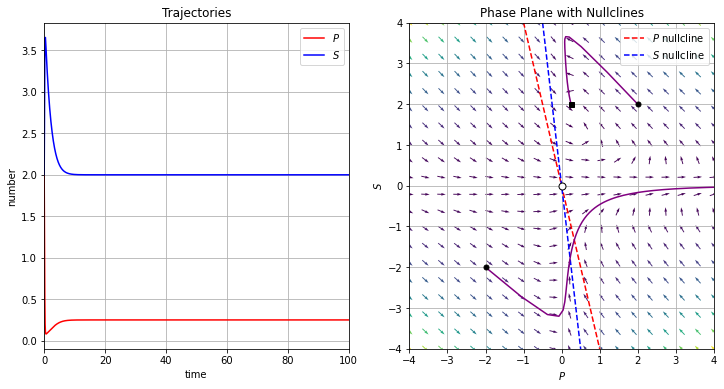

In [ ]:
# Stable example, k2=0.5
k2 = 0.5
a= np.array([[-1/k2**2, -2*k2],[1/k2**2, k2]])
phaseplane_linear(k2, t_end=100, filename="lin_unstable.pdf")